# 1. Problem statement

## i) Describe the dataset

###  The dataset includes records of traffic incidents, each characterized by a range of temporal, geographical, and demographic features. The primary attributes are as follows:
### BOROUGH, LATITUDE, LONGITUDE, NUMBER OF PERSONS INJURED, NUMBER OF PERSONS KILLED, NUMBER OF PEDESTRIANS INJURED, NUMBER OF PEDESTRIANS KILLED, NUMBER OF CYCLIST INJURED, NUMBER OF CYCLIST KILLED, NUMBER OF MOTORIST INJURED, NUMBER OF MOTORIST KILLED, CRASH TIME, HIGH_CRASH

### I will create more columns with the CRASH TIME, such as:
### DAY_OF_WEEK, MONTH, IS_WEEKEND




## ii) Analyze the target variable

### My target variable is the highest crash: HIGH_CRASH.



## iii) Prediction goal

### The objective of this prediction is to determine if a specific time period, defined as a "4-hour window," is likely to be categorized as a high-crash period. The target variable, HIGH_CRASH, is assigned a value of 1 if the number of incidents during the 4-hour window exceeds the median crash count, and 0 otherwise. This binary classification model aims to identify high-crash periods based on various features, including temporal, geographic, and incident-related factors.

# 2. Basic data cleaning

### Drop unwanted features.  Address missing values.  Remove Duplicates. Check if there are any inconsistent inputs for categorical variables. Transform categorical variables into numeric. Use boxplots or histogram to identify outliers for numeric variables and remove them. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Drop unwanted features

# Load data
df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', low_memory=False)

print('Data size:',len(df))

# copy 20% of the data since it is too large
data = df.sample(frac=0.2, random_state=42)

print('New data size:',len(data))

Data size: 2131160
New data size: 426232


In [3]:
# Date Overview
data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
1271117,08/31/2015,7:12,BROOKLYN,11203,40.639510,-73.944442,"(40.63951, -73.9444425)",VICTOR ROAD,EAST 34 STREET,NaN,...,Unspecified,NaN,NaN,NaN,3287542,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN
1986034,01/26/2023,8:29,NaN,NaN,40.602990,-74.121590,"(40.60299, -74.12159)",QUEEN STREET,ELVIN STREET,NaN,...,Unspecified,NaN,NaN,NaN,4600659,Sedan,Sedan,NaN,NaN,NaN
2000631,03/05/2023,1:45,NaN,NaN,40.677715,-73.935870,"(40.677715, -73.93587)",ATLANTIC AVENUE,NaN,NaN,...,Unsafe Speed,NaN,NaN,NaN,4610251,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1355399,04/18/2015,1:11,BRONX,10465,40.878290,-73.870058,"(40.8782895, -73.8700582)",EAST GUNHILL ROAD,BRONX RIVER PARKWAY,NaN,...,Unspecified,NaN,NaN,NaN,3204582,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
748220,12/10/2017,5:00,BROOKLYN,11203,40.646862,-73.920950,"(40.646862, -73.92095)",NaN,NaN,5912 BEVERLEY ROAD,...,Unspecified,Unspecified,NaN,NaN,3806762,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN


In [4]:
# Date types
data.dtypes

CRASH DATE                        object
CRASH TIME                        object
BOROUGH                           object
ZIP CODE                          object
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                          object
ON STREET NAME                    object
CROSS STREET NAME                 object
OFF STREET NAME                   object
NUMBER OF PERSONS INJURED        float64
NUMBER OF PERSONS KILLED         float64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
COLLISION_ID                       int64
VEHICLE TYPE COD

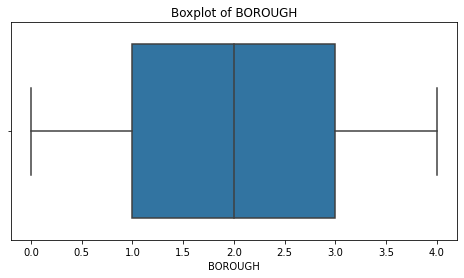

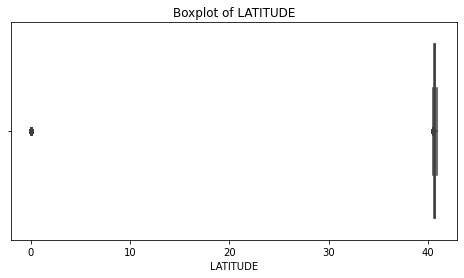

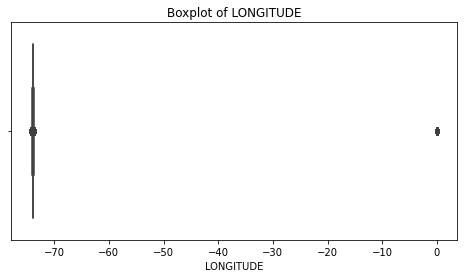

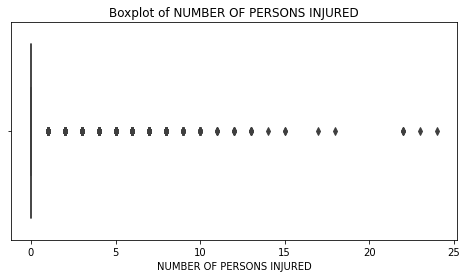

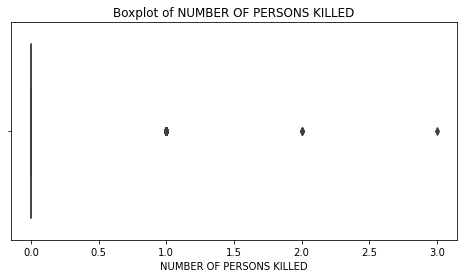

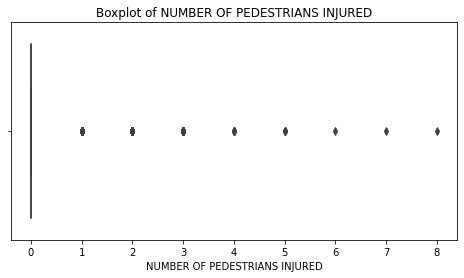

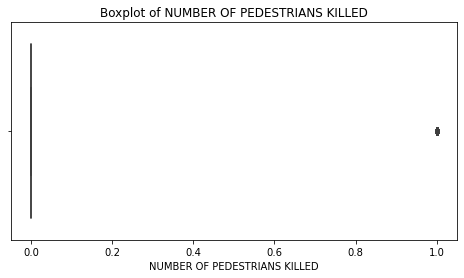

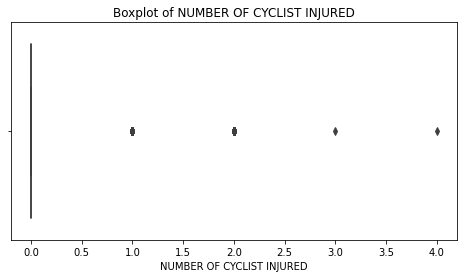

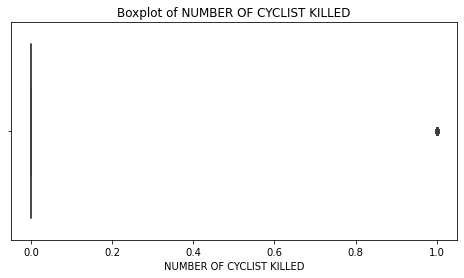

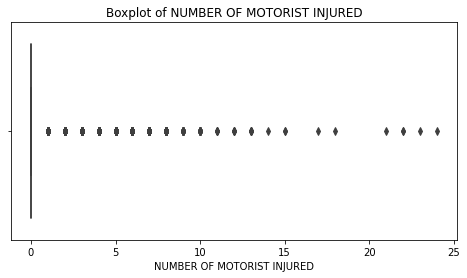

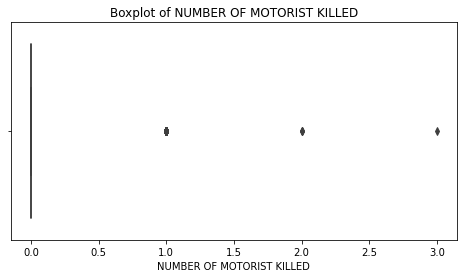

In [5]:
# Address missing values

# Drop unwanted columns 
columns_to_drop = [
    'ZIP CODE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 
    'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 
    'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 
    'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 
    'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'
]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Remove rows where CRASH DATE, CRASH TIME and BOROUGH are not given.
data = data.dropna(subset=['CRASH DATE', 'CRASH TIME', 'BOROUGH'])


# Transform BOROUGH categorical variables into numeric.
data.loc[:, 'BOROUGH'] = data['BOROUGH'].astype('category').cat.codes

# Remove Duplicates.
data = data.drop_duplicates()

# Use boxplots or histogram to identify outliers for numeric variables and remove them
numeric_columns = ['BOROUGH', 'LATITUDE', 'LONGITUDE', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
            'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
            'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 
            'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']


# Plot boxplots for numeric columns
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Define a function to remove outliers based on IQR
def remove_outliers(dfs, columns, threshold=1.5):
    for col in columns:
        Q1 = dfs[col].quantile(0.25)
        Q3 = dfs[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        dfs = dfs[(dfs[col] >= lower_bound) & (dfs[col] <= upper_bound)]
    return df

# Remove outliers
data = remove_outliers(data, numeric_columns)

# 3. Feature Engineering. 

### Feature selection. Use graphs, ANOVA test, Chi-squared test to reduce the dimension. Any variables with zero to little variance?  Any features Irrelevant to the target variable? Any high-correlated Features?   Feature scaling. Does this algorithm require normalized data or standardized data? Are there any categorical variables need to be changed to dummy variables?


In [ ]:
# Data preparation
data['CRASH_DATETIME'] = pd.to_datetime(data['CRASH DATE'].str.cat(data['CRASH TIME'], sep=' '), errors='coerce')
data = data.dropna(subset=['CRASH_DATETIME'])
data['HOUR'] = data['CRASH_DATETIME'].dt.hour
data['4HR_WINDOW'] = data['HOUR'] // 4
data['DAY_OF_WEEK'] = data['CRASH_DATETIME'].dt.dayofweek
data['MONTH'] = data['CRASH_DATETIME'].dt.month
data['IS_WEEKEND'] = data['DAY_OF_WEEK'].isin([5, 6]).astype(int)

# Calculate crash counts per 4-hour window
window_crash_counts = data.groupby('4HR_WINDOW').size().reset_index(name='CRASH_COUNT')

# Calculate the median crash count
median_crash_count = window_crash_counts['CRASH_COUNT'].median()

# Create the 'HIGH_CRASH' column
data['HIGH_CRASH'] = (data['4HR_WINDOW'].map(window_crash_counts.set_index('4HR_WINDOW')['CRASH_COUNT']) > median_crash_count).astype(int)

# Target variable 


data.head()

In [ ]:
# Plot crash counts per 4-hour window to visualize the peak periods
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='4HR_WINDOW', y='CRASH_COUNT', data=window_crash_counts)
plt.xlabel('4-Hour Window', size= 16)
plt.ylabel('Number of Crashes', size= 16)
plt.title('Number of Crashes by 4-Hour Window', size=20)
plt.show()

print('\nThere is high correlation between crashes and crash time (4HR_WINDOW).')
print('This algorithm does not require data normalization or standardization.')
print('There are no categorical variables that need to be changed to dummy variables.')

# 4. Build the prediction model


### Does this data need to be balanced? Do you use train_test_split or cross validation to validate the result?Which algorithm is appropriate for this problem? Which metrics do you use to evaluate the prediction model? If the accuracy score or r-squared score is low, generally it is considered as a bad model. Explain why your model failed. 


In [ ]:
# Feature 
features = ['BOROUGH','LATITUDE', 'LONGITUDE', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
            'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
            'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'DAY_OF_WEEK',
            'MONTH', 'IS_WEEKEND']
X = data[features]

# Target
y = data['HIGH_CRASH']

# Train-test split with SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


# Adjust param_grid as needed to explore more models
param_grid = [{
    'max_depth': [4, 5, 6],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [200, 300, 400],
    'min_samples_leaf': [200, 300, 400],
    'n_estimators': [10, 20, 50]
}]

# Using GridSearchCV with F1 as scoring and StratifiedKFold
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
best_model = grid_search.best_estimator_

# Cross-validation with additional metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}
cv_results = cross_val_score(best_model, X_test, y_test, cv=StratifiedKFold(n_splits=5), scoring='f1')
print("Cross-validated F1 Score:", np.mean(cv_results))

# Model evaluation on test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
feature_importance = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Important Features for Crash Prediction')
plt.show()

## Does this data need to be balanced?

### The data appears to be partially imbalanced, as indicated by the support counts: there are significantly more examples of class 1 (31,442) compared to class 0 (11,779). This imbalance may result in biased model predictions that favor the majority class. This is evident in the high precision and recall for class 1, alongside the comparatively poor performance for class 0.

## Do you use train_test_split or cross validation to validate the result?

### Due to the imbalanced data, I used both Cross-validation and train-test split in this model.
### Cross-validation is generally a better approach for validating results. While the train-test split offers only a single evaluation of the model's performance, cross-validation provides a more robust estimate by averaging performance across multiple splits. This method reduces the risk of results being affected by a specific data split. When dealing with imbalanced data, stratified cross-validation is particularly beneficial, as it ensures that each fold contains a representative distribution of classes, leading to more reliable evaluations.

## Which algorithm is appropriate for this problem? 


### I chose Random Forest due to the classification nature of the problem and the imbalance in the target variable, which makes it more suitable.

## Which metrics do you use to evaluate the prediction model?

### F1 Score: Balances precision and recall, giving a more accurate measure for each class, particularly the minority class. This metric helps ensure that the model is not overfitting to the majority class.

### ROC AUC Score: Evaluates how well the model distinguishes between the two classes across different threshold values. However, the current score of 0.577 suggests the model isn’t distinguishing very effectively, which is something to work on.

### Precision and Recall: Precision tells us the accuracy of the positive predictions, while recall (or sensitivity) tells us how many actual positives were correctly identified. For an imbalanced dataset, both precision and recall, particularly for the minority class, should be closely monitored.

### Confusion Matrix: This provides a detailed breakdown of the model’s predictions for each class, showing where the model may be missing minority class predictions (in this case, false negatives for class 0 are relatively high)

## If the accuracy score or r-squared score is low, generally it is considered as a bad model. Explain why your model failed. 

### My model did not fail; it can be considered acceptable based on the outcome. The F1 score and the cross-validated F1 score are both reasonably strong, at 0.76+ and 0.84+, respectively. This indicates that the model effectively captures patterns in the data. Additionally, the model demonstrates a fair balance between precision and recall for the majority class, allowing it to effectively identify high-crash periods.